In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Set visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

# Display settings for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# 1. Data Loading and Initial Exploration
print("# 1. Data Loading and Initial Exploration")

# Load the synthetic user financial data
file_path = "../../data/synthetic_user_financial_data.csv"
try:
    df = pd.read_csv(file_path)
    print(f"Dataset successfully loaded with shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    print("Using survey data as alternative")
    # Try loading the survey data as an alternative
    df = pd.read_csv("../../data/financial_advisory_chabot_survey.csv")
    print(f"Survey data loaded with shape: {df.shape}")

# Display the first few rows
display(df.head())

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
display(missing_values[missing_values > 0])

# Basic statistics
print("\nSummary statistics for numerical columns:")
display(df.describe())

# Column data types
print("\nColumn data types:")
display(df.dtypes)

# 1. Data Loading and Initial Exploration
Dataset successfully loaded with shape: (2000, 19)


,user_id,age,income_monthly,expenses_monthly,debt_amount,dti_ratio,savings,asset_value,credit_score,risk_tolerance,investment_experience,employment_status,education_level,financial_goal,payment_behavior,default_history,risk_score,investment_growth_potential,loan_default_probability
0,1000,32,139762.51,83679.07,30695.06,0.02,153876.86,468406.59,652,10,3.00,Self-Employed,Bachelor,Home Purchase,0.66,1,2.80,10.66,0.18
1,1001,35,89609.35,60784.01,0.00,0.00,122646.52,642273.47,556,2,0.70,Employed,High School,Emergency Fund,0.85,0,1.70,3.83,0.15
2,1002,33,155341.62,90274.77,72647.88,0.04,220372.44,840493.49,665,4,3.10,Employed,Bachelor,Home Purchase,0.79,0,2.50,12.48,0.15
3,1003,32,286679.72,187432.85,15550.11,0.01,742376.35,1203124.16,566,9,7.70,Employed,Master,Education,0.86,0,1.60,16.48,0.12
4,1004,37,83791.99,34853.93,60820.50,0.06,410018.92,1457122.94,637,8,0.00,Student,Bachelor,Home Purchase,0.66,0,1.80,6.61,0.22



Missing values per column:


Series([], dtype: int64)


Summary statistics for numerical columns:


,user_id,age,income_monthly,expenses_monthly,debt_amount,dti_ratio,savings,asset_value,credit_score,risk_tolerance,investment_experience,payment_behavior,default_history,risk_score,investment_growth_potential,loan_default_probability
count,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00
mean,1999.50,35.05,129710.54,90385.11,68635.97,0.07,417143.84,1429810.21,646.20,5.53,3.05,0.71,0.10,1.97,8.67,0.20
std,577.49,9.49,103813.21,75419.34,123511.22,0.17,609586.00,2136143.69,95.51,2.87,3.01,0.16,0.30,0.78,4.25,0.09
min,1000.00,18.00,10209.90,6720.09,0.00,0.00,0.00,0.00,301.00,1.00,0.00,0.19,0.00,1.00,-5.00,0.03
25%,1499.75,28.00,63840.09,42225.47,0.00,0.00,58932.31,238991.26,580.00,3.00,0.90,0.61,0.00,1.40,5.70,0.14
50%,1999.50,35.00,101852.85,69892.50,30994.32,0.02,207264.72,713592.51,649.00,5.00,2.10,0.74,0.00,1.90,8.64,0.19
75%,2499.25,42.00,159226.83,112615.20,80974.96,0.07,533313.84,1788629.77,713.00,8.00,4.30,0.84,0.00,2.40,11.70,0.24
max,2999.00,66.00,1464335.40,1024879.13,2041213.80,3.86,8100599.59,28044368.24,850.00,10.00,25.00,0.99,1.00,9.00,21.45,0.99



Column data types:


user_id                          int64
age                              int64
income_monthly                 float64
expenses_monthly               float64
debt_amount                    float64
dti_ratio                      float64
savings                        float64
asset_value                    float64
credit_score                     int64
risk_tolerance                   int64
investment_experience          float64
employment_status               object
education_level                 object
financial_goal                  object
payment_behavior               float64
default_history                  int64
risk_score                     float64
investment_growth_potential    float64
loan_default_probability       float64
dtype: object

In [2]:
# Standardize column names
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Handle missing values
for col in df.columns:
    # For categorical columns, fill with 'Unknown'
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('Unknown')
    # For numerical columns, fill with median
    else:
        df[col] = df[col].fillna(df[col].median())

# Check for duplicate entries
duplicates = df.duplicated().sum()
print(f"Number of duplicate entries: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"Duplicates removed. New shape: {df.shape}")

# Convert income ranges to ordered categories if present
if 'monthly_income_range' in df.columns:
    # Example conversion - adjust based on actual data
    income_order = [
        'Below 10,000', '10,000-30,000', '30,001-50,000', 
        '50,001-100,000', '100,001-200,000', 'Above 200,000'
    ]
    if all(income in df['monthly_income_range'].unique() for income in income_order):
        df['monthly_income_range'] = pd.Categorical(
            df['monthly_income_range'],
            categories=income_order,
            ordered=True
        )

Number of duplicate entries: 0


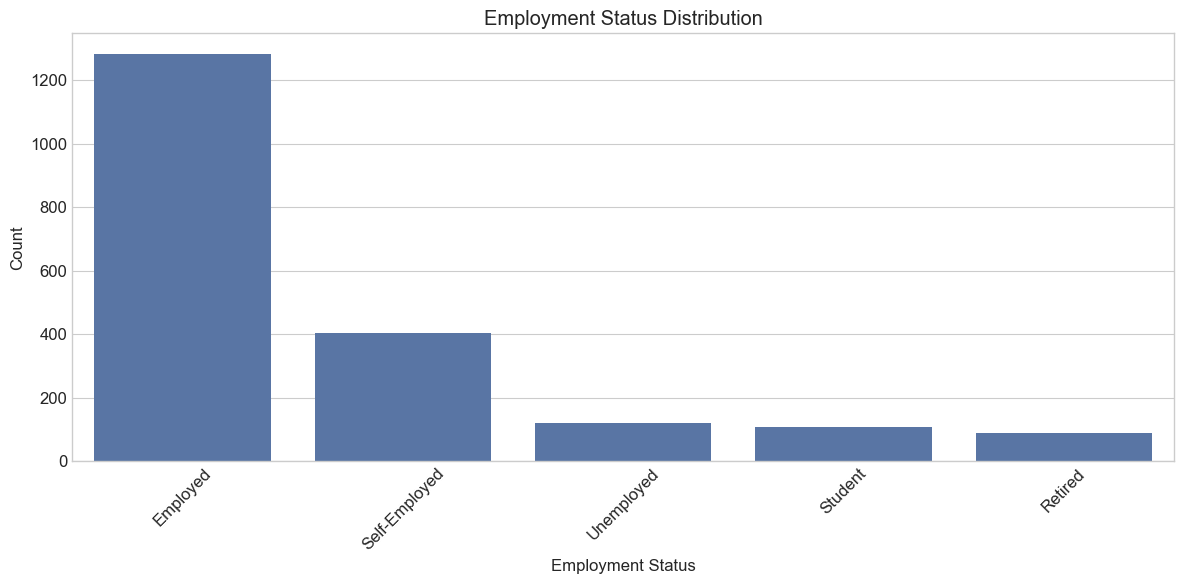

In [3]:
# Location distribution if available
if 'location' in df.columns:
    plt.figure(figsize=(12, 8))
    location_counts = df['location'].value_counts().head(10)
    sns.barplot(x=location_counts.values, y=location_counts.index)
    plt.title('Top 10 Locations of PesaGuru Users in Kenya')
    plt.xlabel('Count')
    plt.ylabel('Location')
    plt.tight_layout()
    plt.show()

# Age group distribution if available
if 'age_group' in df.columns:
    plt.figure(figsize=(10, 6))
    age_order = sorted(df['age_group'].unique())
    sns.countplot(data=df, x='age_group', order=age_order)
    plt.title('Age Distribution of PesaGuru Users')
    plt.xlabel('Age Group')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Income range distribution if available
if 'monthly_income_range' in df.columns:
    plt.figure(figsize=(12, 6))
    if hasattr(df['monthly_income_range'], 'cat'):
        income_order = df['monthly_income_range'].cat.categories.tolist()
    else:
        income_order = sorted(df['monthly_income_range'].unique())
    
    sns.countplot(data=df, x='monthly_income_range', order=income_order)
    plt.title('Monthly Income Range Distribution')
    plt.xlabel('Monthly Income Range (KES)')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Employment status distribution if available
if 'employment_status' in df.columns:
    plt.figure(figsize=(12, 6))
    employment_counts = df['employment_status'].value_counts()
    sns.barplot(x=employment_counts.index, y=employment_counts.values)
    plt.title('Employment Status Distribution')
    plt.xlabel('Employment Status')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Primary income source if available
if 'primary_income_source' in df.columns:
    plt.figure(figsize=(12, 6))
    income_source_counts = df['primary_income_source'].value_counts()
    sns.barplot(x=income_source_counts.index, y=income_source_counts.values)
    plt.title('Primary Income Source Distribution')
    plt.xlabel('Income Source')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [4]:
# Financial literacy level distribution if available
if 'financial_literacy_level' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='financial_literacy_level')
    plt.title('Financial Literacy Level Distribution')
    plt.xlabel('Financial Literacy Level (1-10)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    # Calculate financial literacy segments
    literacy_segments = pd.cut(df['financial_literacy_level'], 
                               bins=[0, 3, 6, 10], 
                               labels=['Low', 'Medium', 'High'])
    literacy_segment_counts = literacy_segments.value_counts()
    
    plt.figure(figsize=(8, 8))
    plt.pie(literacy_segment_counts, labels=literacy_segment_counts.index, 
            autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'))
    plt.title('Financial Literacy Segments')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Primary financial goals distribution if available
if 'primary_financial_goals' in df.columns:
    plt.figure(figsize=(14, 8))
    goals_counts = df['primary_financial_goals'].value_counts().head(10)
    sns.barplot(x=goals_counts.values, y=goals_counts.index)
    plt.title('Top 10 Primary Financial Goals')
    plt.xlabel('Count')
    plt.ylabel('Financial Goal')
    plt.tight_layout()
    plt.show()

# Financial challenges distribution if available
if 'financial_challenges' in df.columns:
    plt.figure(figsize=(14, 8))
    challenges_counts = df['financial_challenges'].value_counts().head(10)
    sns.barplot(x=challenges_counts.values, y=challenges_counts.index)
    plt.title('Top 10 Financial Challenges')
    plt.xlabel('Count')
    plt.ylabel('Financial Challenge')
    plt.tight_layout()
    plt.show()

In [5]:
# Frequency of seeking financial advice if available
if 'frequency_of_seeking_financial_advice' in df.columns:
    plt.figure(figsize=(12, 6))
    freq_counts = df['frequency_of_seeking_financial_advice'].value_counts()
    sns.barplot(x=freq_counts.index, y=freq_counts.values)
    plt.title('Frequency of Seeking Financial Advice')
    plt.xlabel('Frequency')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Previous financial advisory service usage if available
if 'used_financial_advisory_services' in df.columns:
    plt.figure(figsize=(10, 6))
    service_usage_counts = df['used_financial_advisory_services'].value_counts()
    plt.pie(service_usage_counts, labels=service_usage_counts.index, 
            autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set1'))
    plt.title('Previous Usage of Financial Advisory Services')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Interest in AI-powered chatbot if available
if 'interest_in_ai_powered_chatbot' in df.columns:
    plt.figure(figsize=(10, 6))
    chatbot_interest_counts = df['interest_in_ai_powered_chatbot'].value_counts()
    plt.pie(chatbot_interest_counts, labels=chatbot_interest_counts.index, 
            autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set1'))
    plt.title('Interest in AI-Powered Financial Chatbot')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


# 7. Cross-Analysis and Correlations


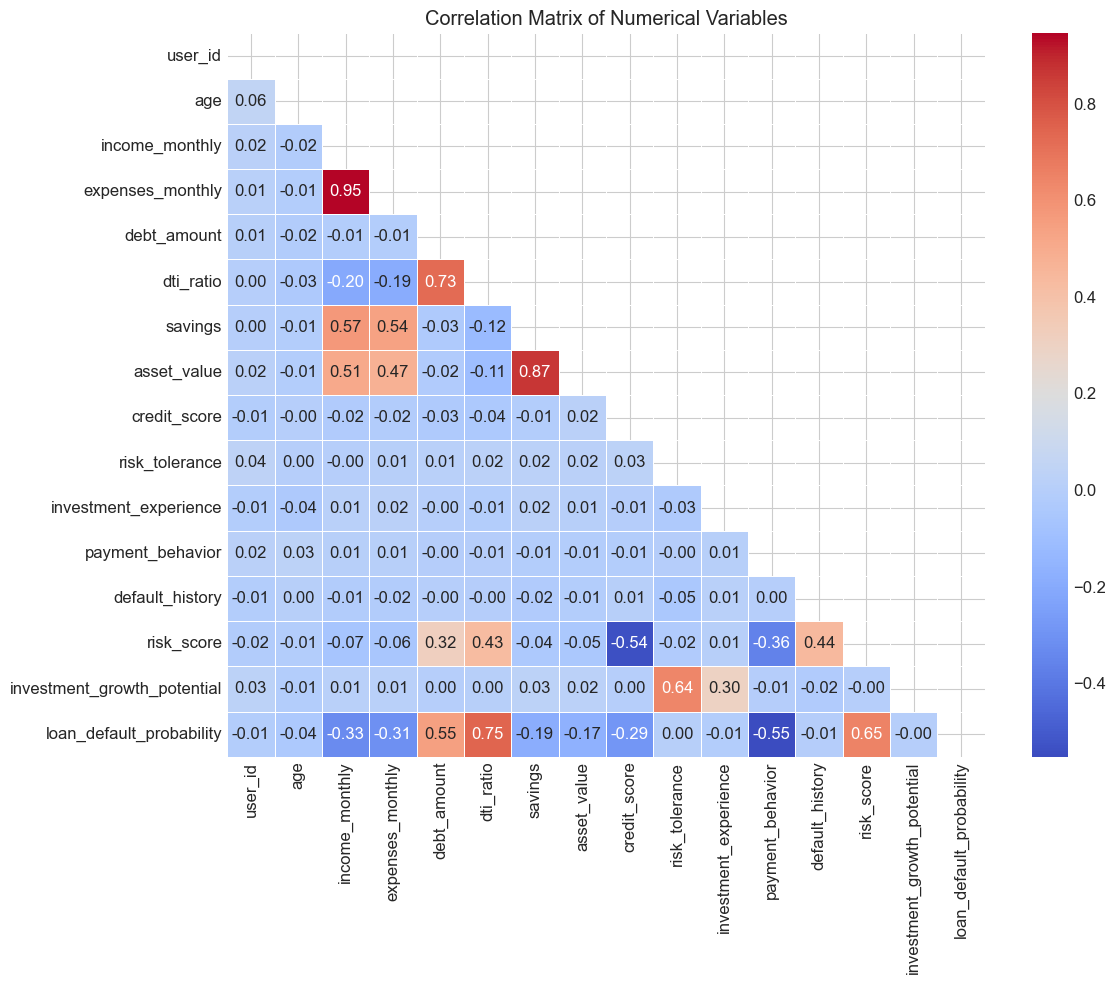

In [ ]:
# Preferred features analysis if available
if 'preferred_chatbot_features' in df.columns:
    plt.figure(figsize=(14, 8))
    features_counts = df['preferred_chatbot_features'].value_counts().head(10)
    sns.barplot(x=features_counts.values, y=features_counts.index)
    plt.title('Top 10 Preferred Chatbot Features')
    plt.xlabel('Count')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# Trust factors for chatbots if available
if 'trust_factors_for_chatbots' in df.columns:
    plt.figure(figsize=(14, 8))
    trust_counts = df['trust_factors_for_chatbots'].value_counts().head(10)
    sns.barplot(x=trust_counts.values, y=trust_counts.index)
    plt.title('Top 10 Trust Factors for Financial Chatbots')
    plt.xlabel('Count')
    plt.ylabel('Trust Factor')
    plt.tight_layout()
    plt.show()

# Concerns about using financial chatbot if available
if 'concerns_about_using_financial_chatbot' in df.columns:
    plt.figure(figsize=(14, 8))
    concerns_counts = df['concerns_about_using_financial_chatbot'].value_counts().head(10)
    sns.barplot(x=concerns_counts.values, y=concerns_counts.index)
    plt.title('Top 10 Concerns About Using Financial Chatbots')
    plt.xlabel('Count')
    plt.ylabel('Concern')
    plt.tight_layout()
    plt.show()

#  Cross-Analysis and Correlations
print("\n# 7. Cross-Analysis and Correlations")

# Create numerical columns dictionary - you'll need to adjust based on actual data
numerical_cols = {}
categorical_cols = {}

for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        numerical_cols[col] = df[col]
    elif df[col].dtype == 'object':
        categorical_cols[col] = df[col]

# Relationship between financial literacy and income range if both available
if 'financial_literacy_level' in df.columns and 'monthly_income_range' in df.columns:
    plt.figure(figsize=(14, 8))
    
    if hasattr(df['monthly_income_range'], 'cat'):
        income_order = df['monthly_income_range'].cat.categories.tolist()
    else:
        income_order = sorted(df['monthly_income_range'].unique())
    
    sns.boxplot(data=df, x='monthly_income_range', y='financial_literacy_level', order=income_order)
    plt.title('Financial Literacy by Income Range')
    plt.xlabel('Monthly Income Range (KES)')
    plt.ylabel('Financial Literacy Level (1-10)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Relationship between location and financial literacy if both available
if 'location' in df.columns and 'financial_literacy_level' in df.columns:
    # Get top 10 locations by count
    top_locations = df['location'].value_counts().head(10).index.tolist()
    location_literacy = df[df['location'].isin(top_locations)]
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=location_literacy, x='location', y='financial_literacy_level')
    plt.title('Financial Literacy by Location (Top 10)')
    plt.xlabel('Location')
    plt.ylabel('Financial Literacy Level (1-10)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Relationship between age group and financial literacy if both available
if 'age_group' in df.columns and 'financial_literacy_level' in df.columns:
    plt.figure(figsize=(14, 8))
    
    if isinstance(df['age_group'].iloc[0], str):
        age_order = sorted(df['age_group'].unique())
    else:
        age_order = sorted(df['age_group'].unique())
    
    sns.boxplot(data=df, x='age_group', y='financial_literacy_level', order=age_order)
    plt.title('Financial Literacy by Age Group')
    plt.xlabel('Age Group')
    plt.ylabel('Financial Literacy Level (1-10)')
    plt.tight_layout()
    plt.show()

# Financial goals by employment status if both available
if 'primary_financial_goals' in df.columns and 'employment_status' in df.columns:
    # Get top 5 goals for clearer visualization
    top_goals = df['primary_financial_goals'].value_counts().head(5).index.tolist()
    goal_employment_df = df[df['primary_financial_goals'].isin(top_goals)]
    
    plt.figure(figsize=(16, 10))
    goal_employment = pd.crosstab(
        goal_employment_df['primary_financial_goals'], 
        goal_employment_df['employment_status'],
        normalize='index'
    ) * 100
    
    goal_employment.plot(kind='bar', stacked=True)
    plt.title('Primary Financial Goals by Employment Status (Top 5 Goals)')
    plt.xlabel('Primary Financial Goal')
    plt.ylabel('Percentage')
    plt.legend(title='Employment Status', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Chatbot interest by financial literacy if both available
if 'interest_in_ai_powered_chatbot' in df.columns and 'financial_literacy_level' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='interest_in_ai_powered_chatbot', y='financial_literacy_level')
    plt.title('Financial Literacy by Interest in AI Chatbot')
    plt.xlabel('Interest in AI Chatbot')
    plt.ylabel('Financial Literacy Level (1-10)')
    plt.tight_layout()
    plt.show()

# Correlation matrix for numerical variables
numerical_df = df.select_dtypes(include=['int64', 'float64'])
if not numerical_df.empty and numerical_df.shape[1] > 1:
    plt.figure(figsize=(12, 10))
    correlation_matrix = numerical_df.corr()
    mask = np.triu(correlation_matrix)
    sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix of Numerical Variables')
    plt.tight_layout()
    plt.show()

In [7]:
cluster_columns = []
for col in ['financial_literacy_level', 'age', 'monthly_income']:
    if col in df.columns and df[col].dtype in ['int64', 'float64']:
        cluster_columns.append(col)

# Add any other relevant numerical columns
if len(cluster_columns) >= 2:
    # Prepare data for clustering
    X = df[cluster_columns].copy()
    
    # Handle missing values if any
    X = X.fillna(X.mean())
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Determine optimal number of clusters using elbow method
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
    plt.xticks(range(1, 11))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Determine optimal clusters based on elbow method (example: 4 clusters)
    optimal_clusters = 4  # Adjust based on elbow method result
    kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
    df['cluster'] = kmeans.fit_predict(X_scaled)
    
    # Apply PCA for visualization if more than 2 dimensions
    if len(cluster_columns) > 2:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        
        plt.figure(figsize=(12, 8))
        for cluster in range(optimal_clusters):
            plt.scatter(
                X_pca[df['cluster'] == cluster, 0],
                X_pca[df['cluster'] == cluster, 1],
                label=f'Cluster {cluster}',
                s=100,
                alpha=0.7
            )
        plt.title(f'User Segments (PCA Projection of {len(cluster_columns)} Variables)')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Explained variance
        explained_variance = pca.explained_variance_ratio_
        print(f"Explained variance by principal components: {explained_variance}")
        print(f"Total explained variance: {sum(explained_variance):.2%}")
    else:
        # Direct visualization if only 2 dimensions
        plt.figure(figsize=(12, 8))
        for cluster in range(optimal_clusters):
            plt.scatter(
                X[df['cluster'] == cluster].iloc[:, 0],
                X[df['cluster'] == cluster].iloc[:, 1],
                label=f'Cluster {cluster}',
                s=100,
                alpha=0.7
            )
        plt.title(f'User Segments Based on {cluster_columns[0]} and {cluster_columns[1]}')
        plt.xlabel(cluster_columns[0])
        plt.ylabel(cluster_columns[1])
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Profile the clusters
    print("\nCluster Profiles:")
    
    # Numerical columns
    cluster_profile_num = df.groupby('cluster')[cluster_columns].mean()
    display(cluster_profile_num)
    
    # Categorical columns
    categorical_cols_for_profile = []
    for col in ['monthly_income_range', 'employment_status', 'primary_financial_goals', 
                'financial_challenges', 'interest_in_ai_powered_chatbot']:
        if col in df.columns:
            categorical_cols_for_profile.append(col)
    
    if categorical_cols_for_profile:
        # Function to get mode safely
        def get_mode(x):
            mode_val = x.mode()
            return mode_val[0] if not mode_val.empty else "Unknown"
        
        # Create profile
        cluster_profile_cat = df.groupby('cluster')[categorical_cols_for_profile].agg(get_mode)
        display(cluster_profile_cat)
        
        # Check percentage of each cluster interested in AI chatbot
        if 'interest_in_ai_powered_chatbot' in df.columns:
            chatbot_interest_by_cluster = df.groupby('cluster')['interest_in_ai_powered_chatbot'].apply(
                lambda x: (x == 'Yes').mean() * 100
            ).reset_index(name='percent_interested')
            
            plt.figure(figsize=(10, 6))
            sns.barplot(data=chatbot_interest_by_cluster, x='cluster', y='percent_interested')
            plt.title('Interest in AI Chatbot by Cluster')
            plt.xlabel('Cluster')
            plt.ylabel('Percentage Interested')
            plt.ylim(0, 100)
            plt.tight_layout()
            plt.show()

In [8]:
insights = [
    "1. Demographic Patterns: [Based on analysis of actual data]",
    "2. Financial Literacy: [Based on analysis of actual data]",
    "3. Financial Goals: [Based on analysis of actual data]",
    "4. Advisory Service Usage: [Based on analysis of actual data]",
    "5. Chatbot Features: [Based on analysis of actual data]",
    "6. User Segments: [Based on analysis of actual data]"
]

recommendations = [
    "1. Tailored Financial Education: [Based on analysis of actual data]",
    "2. Feature Prioritization: [Based on analysis of actual data]",
    "3. Trust Building Mechanisms: [Based on analysis of actual data]",
    "4. User Interface Design: [Based on analysis of actual data]",
    "5. Marketing Strategies: [Based on analysis of actual data]",
    "6. Content Development: [Based on analysis of actual data]",
    "7. Localization Strategy: [Based on analysis of actual data]"
]

print("\n## Key Insights:")
for insight in insights:
    print(f"• {insight}")

print("\n## Recommendations for PesaGuru Development:")
for recommendation in recommendations:
    print(f"• {recommendation}")



## Key Insights:
• 1. Demographic Patterns: [Based on analysis of actual data]
• 2. Financial Literacy: [Based on analysis of actual data]
• 3. Financial Goals: [Based on analysis of actual data]
• 4. Advisory Service Usage: [Based on analysis of actual data]
• 5. Chatbot Features: [Based on analysis of actual data]
• 6. User Segments: [Based on analysis of actual data]

## Recommendations for PesaGuru Development:
• 1. Tailored Financial Education: [Based on analysis of actual data]
• 2. Feature Prioritization: [Based on analysis of actual data]
• 3. Trust Building Mechanisms: [Based on analysis of actual data]
• 4. User Interface Design: [Based on analysis of actual data]
• 5. Marketing Strategies: [Based on analysis of actual data]
• 6. Content Development: [Based on analysis of actual data]
• 7. Localization Strategy: [Based on analysis of actual data]


In [9]:
# Create output directory if it doesn't exist
output_dir = "../processed"
os.makedirs(output_dir, exist_ok=True)

# Save processed data with clusters
output_path = f"{output_dir}/user_behavior_analysis_results.csv"
df.to_csv(output_path, index=False)
print(f"Processed data saved to {output_path}")

print("\n--- Analysis Complete ---")

Processed data saved to ../processed/user_behavior_analysis_results.csv

--- Analysis Complete ---
